# Implementing FCWT - Wavelet Transformation Py C++ Lib


/home/sc.uni-leipzig.de/ju554xqou/.conda/envs/rhoneCube/lib:$LD_LIBRARY_PATH



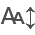

In [3]:
#python basemodules and jupyter modules
import os
import sys
import multiprocessing as mp
from IPython.display import display
from dotenv import load_dotenv

############# Base paths and folder names #############
# get the base path of the repository
repo_dir = os.popen('git rev-parse --show-toplevel').read().strip()
###load the .env file
load_dotenv(dotenv_path=f"{repo_dir}/.env")
print(os.environ.get('LD_LIBRARY_PATH'))

#benchmarking
import time
import cProfile
import pstats
import io

# data handling
import h5py
import xarray as xr
import numpy as np
import pandas as pd
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=False)
import scipy
from scipy import signal, fft
import dask.array as da
import pickle
import fcwt


## lets test FCWT:

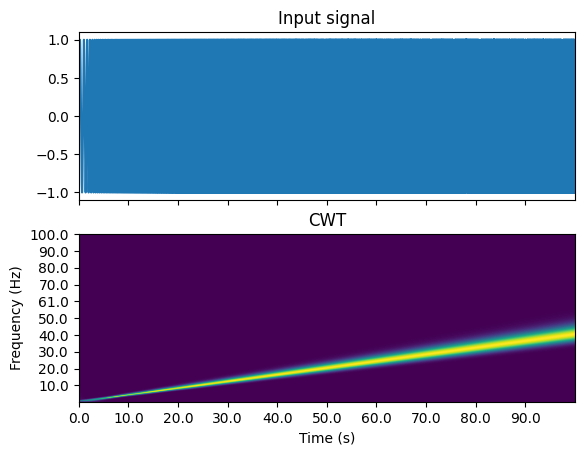

In [4]:
#Initialize
fs = 1000
n = fs*100 #100 seconds
ts = np.arange(n)

#Generate linear chirp
signal = np.sin(2*np.pi*((1+(20*ts)/n)*(ts/fs)))

f0 = 1 #lowest frequency
f1 = 101 #highest frequency
fn = 200 #number of frequencies

#Calculate CWT without plotting...
freqs, out = fcwt.cwt(signal, fs, f0, f1, fn)

#... or calculate and plot CWT
fcwt.plot(signal, fs, f0=f0, f1=f1, fn=fn)

In [5]:
base="/work/le837wmue-Rhone-download/le837wmue-Rhone_download-1720747219/DAS_2020"
os.chdir(base)
folders=os.listdir()
#print(folders)
os.chdir(f"{base}/{folders[0]}")
files=os.listdir()
print("Number of files in folder 1:", len(files))
files[0:10]

Number of files in folder 1: 2880


['rhone1khz_UTC_20200715_092120.719.h5',
 'rhone1khz_UTC_20200715_075250.719.h5',
 'rhone1khz_UTC_20200715_144620.719.h5',
 'rhone1khz_UTC_20200715_193850.719.h5',
 'rhone1khz_UTC_20200715_175650.719.h5',
 'rhone1khz_UTC_20200715_044220.719.h5',
 'rhone1khz_UTC_20200715_192520.719.h5',
 'rhone1khz_UTC_20200715_045050.719.h5',
 'rhone1khz_UTC_20200715_174420.719.h5',
 'rhone1khz_UTC_20200715_193750.719.h5']

In [6]:
cpu_count=mp.cpu_count()*2//3 # we tae two thirds so the open file limit is not exceeded
cpu_count

def read_file(file):
    xr_h5=xr.open_dataset(file, engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
    xr_h5["Acoustic"].compute().values

start=time.time()
pool=mp.Pool(cpu_count)
pool.map(read_file, files[0:40])
pool.close()
pool.join()
end=time.time()
print("Time elapsed:", end-start) 

Time elapsed: 6.426554918289185


In [7]:
# Ensure that 'files' contains the .h5 file you want to work with
print("Number of files in folder 1:", len(files))
print(files[0:10])  # Print first 10 files to verify

# Adjust the file path to use the first file in the list, assuming it's the correct .h5 file
file_path = files[0]  # Adjust index if needed

# Now, use the correct file path
f = h5py.File(file_path, 'r')  # Use the actual file path
dset = f['Acoustic']
data = np.array(dset) 

Number of files in folder 1: 2880
['rhone1khz_UTC_20200715_092120.719.h5', 'rhone1khz_UTC_20200715_075250.719.h5', 'rhone1khz_UTC_20200715_144620.719.h5', 'rhone1khz_UTC_20200715_193850.719.h5', 'rhone1khz_UTC_20200715_175650.719.h5', 'rhone1khz_UTC_20200715_044220.719.h5', 'rhone1khz_UTC_20200715_192520.719.h5', 'rhone1khz_UTC_20200715_045050.719.h5', 'rhone1khz_UTC_20200715_174420.719.h5', 'rhone1khz_UTC_20200715_193750.719.h5']


In [8]:
##########Base settings#########
# Section
loc_a, loc_e = 0, 9200  # Cable section to be processed (in meters) - 0 == start
ind_a, ind_e = loc_a // 4, loc_e // 4  # Channel distances (4m each)
nFiles = 5  # Number of h5 files processed
nCores = 8  # CPU cores

# Additional parameters:
file_length = 30  # Length of a single h5 file in seconds
NU = 1000  # Sampling frequency in Hz of the recorded data
freq_max = 100  # Maximum frequency cut off value for the analysis
seg_length = 1  # Segment length in seconds
seg_len = int(seg_length * NU)  # How many time points should be in one processing window
hop = int(seg_len / 2)  # Hop size for overlapping segments

# Path and name of resulting zarr-formatted data cube.
ZARR_NAME = "cryo_cube.zarr"

def channel_wavelet_fcwt(data, seg_len, hop, NU, freq_max, ind_a, ind_e):
    """
    Applies Wavelet Transformation to segments of DAS records to compute time-frequency representations.

    Args:
        data (ndarray): The raw data from DAS channels.
        seg_len (int): Segment length.
        hop (int): Hop size.
        NU (int): Sampling frequency.
        freq_max (int): Maximum frequency for wavelet transformation.
        ind_a (int): Start index for channels.
        ind_e (int): End index for channels.

    Returns:
        ndarray: A 3D array containing the Wavelet transform for each segment and channel.
    """
    positions = np.arange(0, data.shape[0] - seg_len, hop)
    segs = [data[pos:pos + seg_len] for pos in positions]  # Dividing the data into segments
    segs = [seg.T[ind_a:ind_e] for seg in segs]  # Transposing the segments to get time series for each channel
    nseg = len(segs)
    nfreqs = freq_max  # Number of frequency bins

    Wsegs = np.zeros((nseg, ind_e - ind_a, nfreqs))

    # Inside the channel_wavelet_fcwt function, adjust the nfreqs based on actual cwt_data output
    for i in range(nseg):
        for channel_number, channel in enumerate(segs[i]):
            freqs, cwt_data = fcwt.cwt(channel, NU, 1, freq_max, nfreqs)
            # Update nfreqs based on the actual output size of cwt_data, if necessary
            nfreqs_actual = cwt_data.shape[1]  # Assuming cwt_data shape is (time_points, frequency_bins)
            if i == 0 and channel_number == 0:  # Adjust the Wsegs array size only once
                Wsegs = np.zeros((nseg, ind_e - ind_a, nfreqs_actual))
            mean_cwt_data = np.mean(10 * np.log(np.abs(cwt_data)**2), axis=0)
            Wsegs[i][channel_number] = mean_cwt_data
    
    return Wsegs

####### Running for only one file for demonstration
file_index = 0
files = [
    'rhone1khz_UTC_20200715_092120.719.h5', 'rhone1khz_UTC_20200715_075250.719.h5',
    'rhone1khz_UTC_20200715_144620.719.h5', 'rhone1khz_UTC_20200715_193850.719.h5',
    'rhone1khz_UTC_20200715_175650.719.h5', 'rhone1khz_UTC_20200715_044220.719.h5',
    'rhone1khz_UTC_20200715_192520.719.h5', 'rhone1khz_UTC_20200715_045050.719.h5',
    'rhone1khz_UTC_20200715_174420.719.h5', 'rhone1khz_UTC_20200715_193750.719.h5'
]  # Example file names

# Open the first file and read data
f = h5py.File(files[file_index], 'r')
dset = f['Acoustic']
data = np.array(dset)  # DAS data

# The windowing function (Tukey window in this case) tapers at the ends, 
# so to avoid losing data at the ends of each file, 
# the end of one file is overlapped with the beginning of the next file.
if file_index != nFiles - 1:
    g = h5py.File(files[file_index + 1], 'r')
    dset2 = g['Acoustic']
    data2 = np.array(dset2)
    data = np.concatenate((data, data2[0:seg_len]), axis=0)

start = time.time()

Wsegs = channel_wavelet_fcwt(data, seg_len, hop, NU, freq_max, ind_a, ind_e)

end = time.time()
print("Time elapsed for fcwt wavelet transform:", end - start)


Time elapsed for fcwt wavelet transform: 74.18488073348999


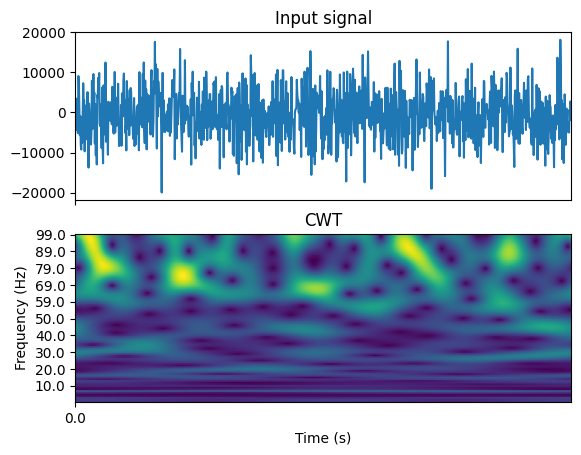

In [10]:
# Assuming this is a Jupyter notebook cell
%matplotlib inline

def plot_first_segment_cwt(data, NU, freq_max, ind_a, ind_e):
    """
    This function computes the CWT for the first segment and first channel,
    then plots the result.
    """
    seg_len = 1024  # Example segment length
    hop = 512  # Example hop size
    positions = np.arange(0, data.shape[0] - seg_len, hop)
    first_seg = data[positions[0]:positions[0] + seg_len].T[ind_a:ind_e]
    first_channel = first_seg[0]  # First channel of the first segment

    # Compute CWT
    #freqs, cwt_data = fcwt.cwt(first_channel, NU, 1, freq_max, 100)

    # Plot the result
    fcwt.plot(first_channel, NU, f0=1, f1=freq_max, fn=100, nthreads=1, scaling="lin", fast=False, norm=True)

# Example call to the function
plot_first_segment_cwt(data, NU, freq_max, ind_a, ind_e)

FFTW library loaded: /home/sc.uni-leipzig.de/ju554xqou/.conda/envs/rhoneCube/lib:$LD_LIBRARY_PATH



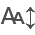

Base data folder:/work/le837wmue-Rhone-download/le837wmue-Rhone_download-1720747219/DAS_2020


In [1]:
############# Import the necessary modules #############
#python basemodules and jupyter modules
import os
import sys
import shutil
import psutil
import multiprocessing as mp
import re
from datetime import datetime, timedelta
from operator import itemgetter
import fnmatch
from dotenv import load_dotenv

# get the base path of the repository
repo_dir = os.popen('git rev-parse --show-toplevel').read().strip()
###load the .env file
load_dotenv(dotenv_path=f"{repo_dir}/.env")
print(f"FFTW library loaded: {os.environ.get('LD_LIBRARY_PATH')}")

#benchmarking
import time
# import cProfile
# import pstats
# import io

# data handling
import h5py
import xarray as xr
import dask.array as da
import numpy as np
import pandas as pd
import scipy
from scipy import signal #, fft
import pyfftw
#import pyfftw.interfaces.dask_fft as dafft
import fcwt
# import pickle
# import zarr

#visualization
import lexcube as lc
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=False)

############# Parse the command line arguments #############
total_cpus = int(mp.cpu_count())

###########get the folder environment vairables#########
base=os.getenv("BASE_FOLDER")
zarr_base=os.getenv("ZARR_BASE_FOLDER")
zarr_base=repo_dir
print(f"Base data folder:{base}")

In [2]:
files_to_process=3
startTime = time.time()


############# Define the functions #############
def get_sorted_folders (base):
    """
    Groups folders by date and sorts them chronologically.
    
    Args:
        base (str): The base folder to search for days.
        
    Returns:
        list: A list of dates in the format "YYYYMMDD".
    """
    
    # Change to the base directory
    os.chdir(base)
    folders = os.listdir()
    
    # Define the date pattern
    date_pattern = re.compile(r"(\d{8})_?\d*")  # Match the date in the folder name
    date_folders = {}

    # Group folders by date
    for folder in folders:
        match = date_pattern.match(folder)
        if match:
            date_str = match.group(1)
            if date_str in date_folders:
                date_folders[date_str].append(folder)
            else:
                date_folders[date_str] = [folder]

    print("Number of folders before moving files:", len(folders))
    
    # Sort folders within each date group
    for date in date_folders:
        date_folders[date].sort(key=lambda x: (x.split('_')[0], int(x.split('_')[1]) if '_' in x else 0))
    
    # Combine folders for each date where there are multiple folders
    for date, folders in date_folders.items():
        if len(folders) > 1:
            combine_folders_with_same_date(folders)
    
    os.chdir(base)
    print("Number of folders after moving files:", len(os.listdir()))        
            
    # sort the dates
    date_folders = dict(sorted(date_folders.items(), key=lambda x: x[0]))        
    
    return list(date_folders.keys())

def combine_folders_with_same_date(folders):
    """
    Combines folders with the same date into one folder.

    Args:
        base (str): The base folder to search for days.
    """
    primary_folder = folders[0]
    folder_path = os.path.join(base, folders[1])
    primary_folder_path = os.path.join(base, primary_folder)
    
    # Move contents to the primary folder
    files=os.listdir(folder_path)
        
    pool=mp.Pool(mp.cpu_count())
    pool.starmap(move_files, [(filename, folder_path, primary_folder_path) for filename in files])
    pool.close()
    pool.join()
    
    # Remove the now-empty folder
    os.system(f"rm -rf {folder_path}")
    print(f"Combined {folders[1]} into {primary_folder}.") 

def move_files(filename, folder_path, primary_folder_path):
    """
    Moves a file from a folder to the primary folder.
    
    Args:
        filename (str): The name of the file to move.
        folder_path (str): The path to the folder containing the file.
        primary_folder_path (str): The path to the primary folder.
    """
    if not os.path.exists(os.path.join(primary_folder_path, filename)): # Check if the file already exists in the primary folder
        join=os.path.join(folder_path, filename)
        shutil.move(join, primary_folder_path) # Move the file to the primary folder
    # else:
    #     print("already exists")

def extract_timestamp(filename):
    """
    Extracts the timestamp from a DAS-h5-file's filename.
    
    Args:
        filename (str): The filename to extract the timestamp from.
        
    Returns:
        str: The timestamp part of the filename.
    """
    # for the format is 'rhone1khz_UTC_yyyymmdd_hhmmss.ms.h5'
    timestamp_part = filename.split('_')[2] + filename.split('_')[3]
    return timestamp_part

def get_filenames(folder, base):
    """
    Collects the filenames in the data folder and sorts them by time.

    Args:
        folder (str): The folder to search for files.

    Returns:
        dict: A dictionary where keys are integers and values are filenames, sorted chronologically.
    """
    # Change to the folder directory
    folder_path = os.path.join(base, folder)
    os.chdir(folder_path)
    files=os.listdir()
    
    # filter files to only get those where the filename contains 'rhone2das' or 'rhone1khz'
    # Use fnmatch.filter to find matches for both patterns in a single pass
    pattern_matches = fnmatch.filter(files, '*rhone2das*') + fnmatch.filter(files, '*rhone1khz*')
    
    # Sort the files by timestamp
    sorted_files = sorted(pattern_matches, key=extract_timestamp)
    
    return  sorted_files 

def channel_wavelet_fcwt(data, args, positions, channel):
    """
    Applies Wavelet Transformation to segments of DAS records to compute time-frequency representations.

    Args:
        data (np.array): The DAS data.
        args (dict): The arguments for the Wavelet transform.
            Args requires the following keys:
                "sample_freq" (int): The sampling frequency.
                "freq_min" (float): The minimum frequency for wavelet transformation.
                "freq_max" (float): The maximum frequency for wavelet transformation.
                "num_frequency_points" (int): The number of frequency points.
                "start_channel_index" (int): The start channel index.
                "end_channel_index" (int): The end channel index.
                "seg_len" (int): The segment length.
                "hop" (int): The hop size.
        positions (np.array): The positions of the segments in the data.

    Returns:
        np.array: The Wavelet transformed segments.
    """

    # Unpack the arguments
    seg_len = args["seg_len"]
    sample_freq = args["sample_freq"]
    freq_min = args["freq_min"]
    freq_max = args["freq_max"]
    num_frequency_points = args["num_frequency_points"]
    n_segments = positions.shape[0]

    # Pre-allocate the segments array
    segments = ([data[pos:pos+seg_len] for pos in positions])
    segments = [seg.T[start_channel_index:end_channel_index] for seg in segments]
    Wsegs = np.zeros((n_segments, channel, num_frequency_points, seg_len), dtype=np.float32)

    for i in range(n_segments):
        for channel_number, channel in enumerate(segments[i]):
            # Perform the wavelet transform
            start=time.time()
            freqs, cwt_output = fcwt.cwt(channel, sample_freq, freq_min, freq_max, num_frequency_points)
            print(f"time:{time.time()-start}")
            Wsegs[i][channel_number] = np.abs(cwt_output)

    return Wsegs  # return the Wavelet transformed segments

def channel_fourier(data, args, taper, positions, channel):
    """
    Applies the Fourier transform to segments of the DAS records using the pyFFTW library.
    
    Args:
        data (np.array): The DAS data.
        args (dict): The arguments for the Fourier transform.
            Args requires the following keys:
                "fft_dtype" (str): The data type for the Fourier transform.
                "num_frequency_points" (int): The number of frequency points.
                "start_channel_index" (int): The start channel index.
                "end_channel_index" (int): The end channel index.
                "seg_len" (int): The segment length.
                "hop" (int): The hop size.
                "n_samples" (int): The number of samples.
        taper (np.array): The taper function.
        positions (np.array): The positions of the segments in the data.
        
    Returns:
        np.array: The Fourier transformed segments.
    """
    
    # Unpack the arguments
    seg_len = args["seg_len"]
    fft_dtype = args["fft_dtype"]  # dtype: float32
    n_segments = positions.shape[0]

    # Pre-allocate the segments array
    segments = ([data[pos:pos+seg_len] for pos in positions])
    segments = [seg.T[0:channel] for seg in segments]
    Fsegs = np.zeros((n_segments, channel, num_frequency_points), dtype=fft_dtype)  # empty float32 array
    
    # Pre-allocate the input array for FFTW
    fft_input = pyfftw.empty_aligned(seg_len, dtype=fft_dtype)
    # Create the FFTW object
    fft_object = pyfftw.builders.rfft(fft_input)  # , planner_effort='FFTW_ESTIMATE') #, threads=mp.cpu_count()//2)
    
    for i in range(n_segments):
        for channel_number, channel in enumerate(segments[i]):
            fft_input[:] = taper * channel  # Apply taper
            #np.multiply(taper, channel, out=fft_input)  # Apply taper
            fft_output = fft_object()  # Execute FFT
            fourier_transformed = (10 * np.log(np.abs(fft_output) ** 2 + 1e-10))[:num_frequency_points]  # Compute power spectrum
            fourier_transformed[0] = 0  # Remove DC component (average value of the signal)
            Fsegs[i][channel_number] = fourier_transformed
    
    return Fsegs  # return the Fourier transformed segments

 
def downsample(data, original_freq, sample_freq):
    factor = original_freq // sample_freq
    #print(f"factor: {factor}, sampling freq:{sample_freq}")
    return data[::factor]

def create_spectro_segment(file_index, args, filelist):
    """
    Creates a spectrogram segment from a file.
    
    Args:
        file_index (int): The index of the file.
        args (dict): The arguments for the Fourier transform.
            Args requires the following keys:
                "n_files" (int): The number of files.
                "seg_len" (int): The segment length.
                "hop" (int): The hop size.
                "n_samples" (int): The number of samples.
        filelist (list): The list of file names.
        
    Returns:
        np.array: The Fourier transformed segments.
        int: The number of segments.
    """
    
    # chunk args
    n_files=args["n_files"]
    seg_len=args["seg_len"]
    hop=args["hop"]
    n_samples=args["n_samples"]
    filename=filelist[file_index]
    float_type=args["fft_dtype"]
    sample_freq=args["sample_freq"]
    freq_coords=args["freq_coords"]
    
    #taper function
    taper = signal.windows.tukey(seg_len, 0.25)  # reduces the amplitude of the discontinuities at the boundaries, thereby reducing spectral leakage.
    
    # Load the data
    # xr_h5 = xr.open_dataset(filename, engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
    # data = xr_h5["Acoustic"].compute().values.astype(float_type)
    
    # Open the HDF5 file in read mode
    with h5py.File(filename, 'r') as f:
        # Access the 'Acoustic' dataset
        acoustic_dataset = f['Acoustic']
        orig_sampling_freq = int(acoustic_dataset.attrs['SamplingFrequency[Hz]'])
        channel=int(float(acoustic_dataset.attrs["MeasureLength[m]"])/int(acoustic_dataset.attrs["SpatialResolution[m]"]))
        # Read the dataset and downsample
        acoustic_data = np.array(acoustic_dataset, dtype=float_type)
        downsampled_data = downsample(acoustic_data, orig_sampling_freq, sample_freq)
        start_time=np.datetime64(acoustic_dataset.attrs["ISO8601 Timestamp"].split("+")[0], 'ns') # Get the start time of the first file
    
    #if not the last file, concatenate the next file
    if file_index < n_files - 1:
        #xr_h5_2 = xr.open_dataset(filelist[file_index + 1], engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
        #data_2 = xr_h5_2["Acoustic"].compute().values.astype(float_type)
        with h5py.File(filename, 'r') as f:
            # Access the 'Acoustic' dataset
            acoustic_dataset = f['Acoustic']
            orig_sampling_freq = int(acoustic_dataset.attrs['SamplingFrequency[Hz]'])
            # Read the dataset and downsample
            acoustic_data = np.array(acoustic_dataset, dtype=float_type)
            downsampled_data2 = downsample(acoustic_data, orig_sampling_freq, sample_freq)
            #next_start_time = np.datetime64(f['Acoustic'].attrs["ISO8601 Timestamp"], 'ns')
        downsampled_data = np.concatenate((downsampled_data, downsampled_data2[0:seg_len]), axis=0)
    
    
    next_file_index = file_index+1
    file_pos = file_index * n_samples

    # If the current file is not the last one
    if file_index != n_files-1:
        # Calculate the starting positions of each segment in the data
        # first segment: (next_file_index-1)*n_samples/hop, rounded up
        # last segment: (next_file_index*n_samples-1)/hop, rounded down
        positions = np.arange(np.ceil((file_index)*n_samples/hop), np.floor((next_file_index*n_samples-1)/hop)+1, dtype=int)*hop - file_pos # scaled by the hop size and offset by the file position
    else:
        # If last one, start: (next_file_index*n_samples-seg_len)/hop
        # to ensure that the last segment doesn't extend beyond the end of the data
        positions = np.arange(np.ceil((file_index)*n_samples/hop), np.floor((next_file_index*n_samples-seg_len)/hop)+1, dtype=int)*hop - file_pos
    #print(positions)
    
    time_res_ms = time_res * 1000  # Convert time_res from seconds to milliseconds
    time_coords = start_time + np.arange(positions.shape[0]) * np.timedelta64(int(time_res_ms), 'ms') 
    
    start=time.time()
    Fsegs = channel_fourier(downsampled_data, args, taper, positions, channel)
    print(f"Time taken for fft of {filename}: {time.time()-start}")
    
    start=time.time()
    #Wsegs = channel_wavelet_fcwt(downsampled_data, args, positions, channel)
    print(f"Time taken for wavelet transformation of {filename}: {time.time()-start}")
    
    fft_dask_array = da.from_array(Fsegs, chunks=(positions.shape[0], channel, num_frequency_points))
    #cwt_dask_array = da.from_array(Wsegs, chunks=(positions.shape[0], channel, num_frequency_points))
    z_shape=(positions.shape[0], channel, num_frequency_points) 
    cwt_dask = da.zeros(z_shape, chunks=(positions.shape[0], channel, num_frequency_points), dtype=float_type) # create another empty dask array for wavelet transformation

    xr_zarr = xr.Dataset(
        {
            "fft": (["time", "channel", "frequency"], fft_dask_array),
            "cwt": (["time", "channel", "frequency"], cwt_dask),
        },
        coords={
            "time": time_coords,
            "channel": np.arange(channel),
            "frequency": freq_coords,
        },
    )
    
    return xr_zarr




##########Base settings#########
#granularity of spectrogram
freq_res = int(os.getenv("FREQ_RES", 1)) # frequency resolution in Hz
time_res = float(os.getenv("TIME_RES", 0.1)) # time res in seconds
float_type = os.getenv("FLOAT_TYPE", 'float32')

# Additional parameters:
file_length = int(os.getenv("FILE_LENGTH", 30)) # Length of a single h5 file in seconds.
sample_freq = int(os.getenv("SAMPLE_FREQ", 200)) # Sampling frequency in Hz of the recorded data.
freq_max = int(os.getenv("FREQ_MAX", 100)) # maximum frequency cut off value for the analysis
seg_length=1/freq_res #calculate window length corresponding to freq_res
n_samples = file_length*sample_freq #number of samples in one file/total number of data points available in one file
num_frequency_points = int(seg_length*freq_max+1)
seg_sample_len=int(seg_length*sample_freq) # how many time points should be in one processing window
n_segments_file=int(2*(file_length/seg_length)) # amount of segments for the desired window length
freq_coords=scipy.fft.rfftfreq(int(sample_freq/freq_res), 1/sample_freq)[:num_frequency_points] # frequency coordinates
hop = int(time_res*sample_freq) # hop size - how many samples to skip between segments

#fft input arguments
args = {
    "fft_dtype": float_type,
    "num_frequency_points" : num_frequency_points,
    "seg_len" : seg_sample_len,
    "hop" : hop,
    "n_samples" : n_samples,
    "seg_length" : seg_length,
    "freq_max" : freq_max,
    "freq_min": 1,
    "sample_freq" : sample_freq,
    "time_res":time_res,
    "freq_coords": freq_coords
}


##########Main#########
if __name__=='__main__':
    
    # set the folder
    folders=get_sorted_folders(base)
    folder=folders[0]
    
    #path and name of resulting zarr-formatted data cube.
    zarr_name = f"cryo_cube_{folder}.zarr"
    zarr_path = f"{zarr_base}/{zarr_name}"
    
    os.chdir(base) # change to the base directory
    print(f"base folder: {os.getcwd()}")
    while os.path.exists(zarr_path) and folders:  # Check if folders is not empty
        folder = folders.pop(0)  # remove and return the first element
        zarr_name = f"cryo_cube_{folder}.zarr"
        zarr_path = f"{zarr_base}/{zarr_name}"
    
    if not folders:
        print("No more folders to process.")
        sys.exit(0)
    else:
        print(f"Processing folder {folder}")
    
    #get the day and month
    day=folder[6:8]
    month=folder[4:6]
    
    # print the settings
    print(20*"*")
    print("Max number of CPUs: ", total_cpus)
    print(f"Processed day: {day}.{month}.2020")
    print(f"Time resolution: {time_res} sec")
    print(f"Frequency resolution: {freq_res} Hz")
    print(f"Resulting overlap: {1-hop/seg_sample_len}")
    print(20*"*")
    
    # get the filenames and the total amount of segments
    filenames = get_filenames(folder, base)[0:int(files_to_process)]
    n_files=len(filenames)
    args["n_files"] = n_files
    #print("filenames", filenames)
    n_segments_total = int(np.floor((n_files*n_samples-seg_sample_len)/hop))+1 # total amount of segments


    print("Creating Zarr path...")
    start=time.time()
    # Create the directory structure for the Zarr store
    #os.makedirs(zarr_path, exist_ok=True)
    print(f"Zarr path created at: {zarr_path} in {time.time()-start}s:")
     
    # In the following lines, multiple cpu-cores calculate
    # a fft for each file simultanously.
    # Before that we split the whole data to be processed in to not overload the memory!

    
    print(20*"*")
    print("Number of files processed:", n_files)
    
    # Determine available system memory 
    available_memory = psutil.virtual_memory().available * 0.8  # Use 80% of available memory (let's reserve some memory for the system and other processes)

    # Calculate how many files can be processed simultaneously
    dummy_file_path=os.path.join(base, folder, filenames[0])
    dummy_xr = xr.open_dataset(filenames[0], engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
    memory_per_file = os.path.getsize(dummy_file_path)*1.5 # 1.5 times the size of the file, assuming some overhead
    print("Memory per file (MB):", memory_per_file / (1024**2))
    files_at_once = int(available_memory / memory_per_file)
    files_at_once = max(1, files_at_once) #1 # Ensure that at least one file is processed at once 
    print(f"Maximum number of files to be processed at once: {files_at_once}")
    
    # Calculate the number of divisions 
    n_div = max(1, n_files // files_at_once)
    index_list = np.arange(n_files)

    # set split up
    if n_files > files_at_once:
        split_up = np.array_split(index_list, n_div)
    else:
        split_up = [index_list]

    print(f"Number of split_ups: {len(split_up)}")
        
    # Define the number of cores to be 90% of available cores, rounded down
    n_cores = int(total_cpus * 0.9) // 1
    print("Number of cores used:", n_cores)
    print(20*"*")

Number of folders before moving files: 34
Number of folders after moving files: 34
base folder: /work/le837wmue-Rhone-download/le837wmue-Rhone_download-1720747219/DAS_2020
Processing folder 20200704
********************
Max number of CPUs:  128
Processed day: 04.07.2020
Time resolution: 0.1 sec
Frequency resolution: 1 Hz
Resulting overlap: 0.9
********************
Creating Zarr path...
Zarr path created at: /home/sc.uni-leipzig.de/ju554xqou/big-data-praktikum/cryo_cube_20200704.zarr in 7.152557373046875e-07s:
********************
Number of files processed: 3
Memory per file (MB): 170.40367126464844
Maximum number of files to be processed at once: 4687
Number of split_ups: 1
Number of cores used: 115
********************


In [ ]:
n_files=args["n_files"]
seg_len=args["seg_len"]
hop=args["hop"]
n_samples=args["n_samples"]
file_index=0
filename=filenames[file_index]
float_type=args["fft_dtype"]
sample_freq=args["sample_freq"]
freq_coords=args["freq_coords"]

#taper function
taper = signal.windows.tukey(seg_len, 0.25)  # reduces the amplitude of the discontinuities at the boundaries, thereby reducing spectral leakage.

# Load the data
# xr_h5 = xr.open_dataset(filename, engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
# data = xr_h5["Acoustic"].compute().values.astype(float_type)

# Open the HDF5 file in read mode
with h5py.File(filename, 'r') as f:
    # Access the 'Acoustic' dataset
    acoustic_dataset = f['Acoustic']
    orig_sampling_freq = int(acoustic_dataset.attrs['SamplingFrequency[Hz]'])
    channel=int(float(acoustic_dataset.attrs["MeasureLength[m]"])/int(acoustic_dataset.attrs["SpatialResolution[m]"]))
    # Read the dataset and downsample
    acoustic_data = np.array(acoustic_dataset, dtype=float_type)
    downsampled_data = downsample(acoustic_data, orig_sampling_freq, sample_freq)
    start_time=np.datetime64(acoustic_dataset.attrs["ISO8601 Timestamp"].split("+")[0], 'ns') # Get the start time of the first file

#if not the last file, concatenate the next file
if file_index < n_files - 1:
    #xr_h5_2 = xr.open_dataset(filelist[file_index + 1], engine='h5netcdf', backend_kwargs={'phony_dims': 'access'})
    #data_2 = xr_h5_2["Acoustic"].compute().values.astype(float_type)
    with h5py.File(filename, 'r') as f:
        # Access the 'Acoustic' dataset
        acoustic_dataset = f['Acoustic']
        orig_sampling_freq = int(acoustic_dataset.attrs['SamplingFrequency[Hz]'])
        # Read the dataset and downsample
        acoustic_data = np.array(acoustic_dataset, dtype=float_type)
        downsampled_data2 = downsample(acoustic_data, orig_sampling_freq, sample_freq)
        #next_start_time = np.datetime64(f['Acoustic'].attrs["ISO8601 Timestamp"], 'ns')
    downsampled_data = np.concatenate((downsampled_data, downsampled_data2[0:seg_len]), axis=0)


next_file_index = file_index+1
file_pos = file_index * n_samples

# If the current file is not the last one
if file_index != n_files-1:
    # Calculate the starting positions of each segment in the data
    # first segment: (next_file_index-1)*n_samples/hop, rounded up
    # last segment: (next_file_index*n_samples-1)/hop, rounded down
    positions = np.arange(np.ceil((file_index)*n_samples/hop), np.floor((next_file_index*n_samples-1)/hop)+1, dtype=int)*hop - file_pos # scaled by the hop size and offset by the file position
else:
    # If last one, start: (next_file_index*n_samples-seg_len)/hop
    # to ensure that the last segment doesn't extend beyond the end of the data
    positions = np.arange(np.ceil((file_index)*n_samples/hop), np.floor((next_file_index*n_samples-seg_len)/hop)+1, dtype=int)*hop - file_pos
#print(positions)

time_res_ms = time_res * 1000  # Convert time_res from seconds to milliseconds
time_coords = start_time + np.arange(positions.shape[0]) * np.timedelta64(int(time_res_ms), 'ms') 

start=time.time()
Wsegs = channel_wavelet_fcwt(downsampled_data, args, positions, channel)

number of segments: 300
time for segment: 0.5742173194885254
time for segment: 0.5776593685150146
time for segment: 0.5809590816497803
time for segment: 0.584810733795166
time for segment: 0.5883774757385254
time for segment: 0.5919184684753418
time for segment: 0.5992007255554199
time for segment: 0.6008174419403076
time for segment: 0.6015429496765137
time for segment: 0.6058485507965088
time for segment: 0.6021144390106201
time for segment: 0.6014983654022217
time for segment: 0.6046414375305176
time for segment: 0.602025032043457
time for segment: 0.6079564094543457
time for segment: 0.6033751964569092
time for segment: 0.601956844329834
time for segment: 0.6077368259429932
time for segment: 0.6031150817871094
time for segment: 0.6056063175201416
time for segment: 0.6055135726928711
time for segment: 0.6078925132751465
time for segment: 0.604729413986206
time for segment: 0.6045005321502686
time for segment: 0.6052885055541992
time for segment: 0.6050028800964355
time for segment: 

In [6]:
def channel_wavelet_fcwt(data, args, positions, channel):
    """
    Applies Wavelet Transformation to segments of DAS records to compute time-frequency representations.

    Args:
        data (np.array): The DAS data.
        args (dict): The arguments for the Wavelet transform.
            Args requires the following keys:
                "sample_freq" (int): The sampling frequency.
                "freq_min" (float): The minimum frequency for wavelet transformation.
                "freq_max" (float): The maximum frequency for wavelet transformation.
                "num_frequency_points" (int): The number of frequency points.
                "start_channel_index" (int): The start channel index.
                "end_channel_index" (int): The end channel index.
                "seg_len" (int): The segment length.
                "hop" (int): The hop size.
        positions (np.array): The positions of the segments in the data.

    Returns:
        np.array: The Wavelet transformed segments.
    """

    # Unpack the arguments
    seg_len = args["seg_len"]
    sample_freq = args["sample_freq"]
    freq_min = args["freq_min"]
    freq_max = args["freq_max"]
    num_frequency_points = args["num_frequency_points"]
    n_segments = positions.shape[0]

    # Pre-allocate the segments array
    segments = ([data[pos:pos+seg_len] for pos in positions])
    segments = [seg.T[0:channel] for seg in segments]
    Wsegs = np.zeros((n_segments, channel, num_frequency_points, seg_len), dtype=np.float32)

    print(f"number of segments: {n_segments}")
    for i in range(n_segments):
        for channel_number, channel in enumerate(segments[i]):
            # Perform the wavelet transform
            freqs, cwt_output = fcwt.cwt(channel, sample_freq, freq_min, freq_max, num_frequency_points)
            Wsegs[i][channel_number] = np.abs(cwt_output)

    return Wsegs  # return the Wavelet transformed segments